<a href="https://colab.research.google.com/github/aatreyipanchal/Text-Classification-Using-RNN/blob/main/Text_Classification_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Preprocessing functions
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

import nltk
nltk.download('stopwords')

def stopword(string):
    return ' '.join([i for i in string.split() if i not in stopwords.words('english')])

def stemming(string):
    snow = SnowballStemmer('english')
    return ' '.join([snow.stem(i) for i in word_tokenize(string)])

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    wl = WordNetLemmatizer()
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    return ' '.join([wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# Load and preprocess data
df_train = pd.read_csv('SPEND_UNSPC.csv')
df_train['clean_text'] = df_train['ITEM_DESC'].apply(lambda x: finalpreprocess(x))
df_train = df_train.drop(columns=['ITEM_DESC'])

# Tokenization and padding
X = df_train['clean_text'].values
y = df_train['SEGMENT'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, shuffle=True)

# Tokenizer and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

max_length = max(max(len(seq) for seq in X_train_sequences), max(len(seq) for seq in X_val_sequences))
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length)

# Build RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(len(le.classes_), activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_val_padded, y_val))

# Evaluate model
y_val_pred = model.predict(X_val_padded)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:\n", classification_report(y_val_true, y_val_pred_classes))
print("Accuracy Score:", accuracy_score(y_val_true, y_val_pred_classes))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-2-6e9dd240cc4d>:68: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('SPEND_UNSPC.csv')


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1335/1335 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.5685 - loss: 1.4840 - val_accuracy: 0.8174 - val_loss: 0.7071
Epoch 2/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.8287 - loss: 0.6359 - val_accuracy: 0.8380 - val_loss: 0.6345
Epoch 3/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.8621 - loss: 0.4946 - val_accuracy: 0.7891 - val_loss: 0.7445
Epoch 4/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.8530 - loss: 0.5172 - val_accuracy: 0.7814 - val_loss: 0.7713
Epoch 5/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.8206 - loss: 0.6263 - val_accuracy: 0.8605 - val_loss: 0.5645
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        28
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         6
           5       0.75      0.13      0.22        46
           6       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [5]:
import keras_tuner as kt
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32), input_length=max_length))
    rnn_layer = hp.Choice('rnn_layer', ['SimpleRNN', 'LSTM', 'GRU'])

    if rnn_layer == 'SimpleRNN':
        model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
    elif rnn_layer == 'LSTM':
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
    elif rnn_layer == 'GRU':
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))

    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(len(le.classes_), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='rnn_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model
y_val_pred = best_model.predict(X_val_padded)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("Classification Report:\n", classification_report(y_val_true, y_val_pred_classes))
print("Accuracy Score:", accuracy_score(y_val_true, y_val_pred_classes))


Trial 30 Complete [00h 08m 09s]
val_accuracy: 0.9176030158996582

Best val_accuracy So Far: 0.986610472202301
Total elapsed time: 02h 13m 00s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 48, 96)              │         480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │           2,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,379 (1.96 MB)

 Trainable params: 513,379 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.86      0.89        28
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         3
           4       1.00      0.83      0.91         6
           5       0.96      0.93      0.95        46
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         0
           8       0.99      0.98      0.98       345
           9       0.91      0.81      0.86        48
          10       0.73      0.67      0.70        24
          11       0.97      0.99      0.98       281
          12       0.95      0.88      0.92       112
          13       0.98      0.98      0.98       108
          14       1.00      1.00      1.00      4470
          15       0.97      1.00      0.98       207
          16       0.99      0.99      0.99      1276
          17   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
y_val_pred_segments = le.inverse_transform(y_val_pred_classes)
y_val_true_segments = le.inverse_transform(y_val_true)

In [11]:
df_test = pd.DataFrame({
    'clean_text': X_val,
    'Actual Segment': y_val_true_segments,
    'Predicted Segment': y_val_pred_segments,
    'Prediction Probability': np.max(y_val_pred, axis=1)
})

# Reset index and save to CSV
final = df_test.reset_index(drop=True)
final.to_csv('Output.csv', index=False)

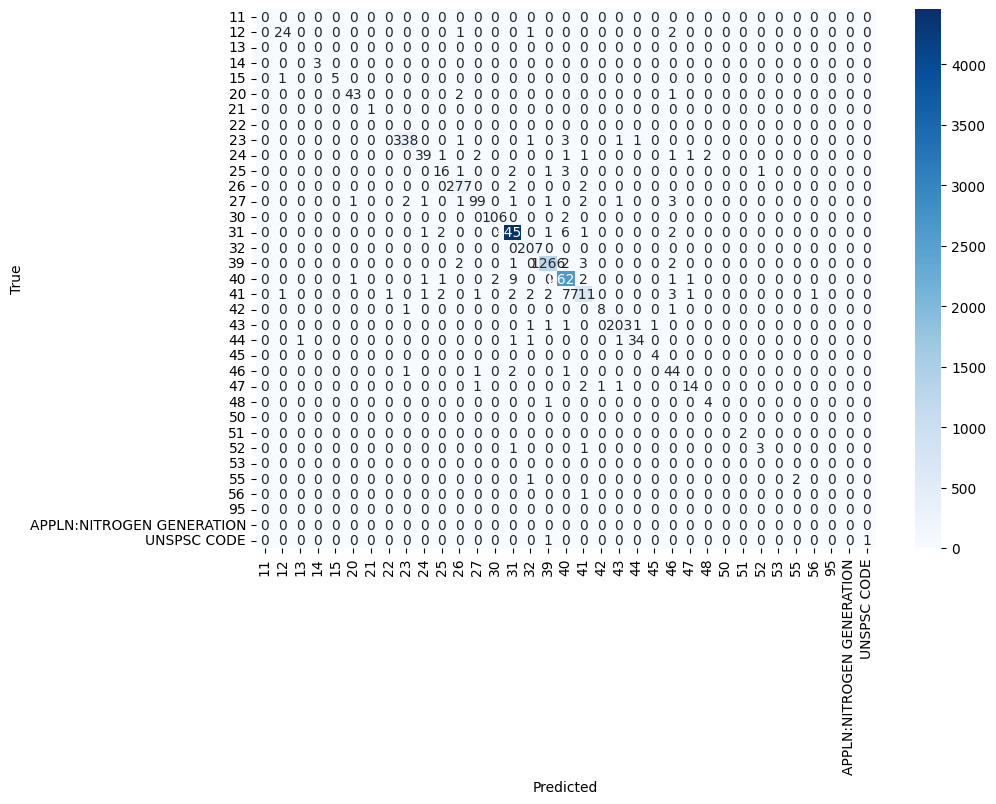

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val_true_segments, y_val_pred_segments, labels=le.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
